Adversarial Test Accuracy: 72.00%


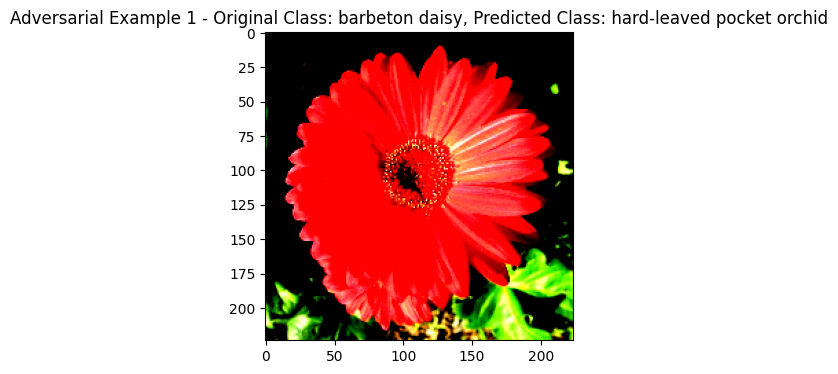

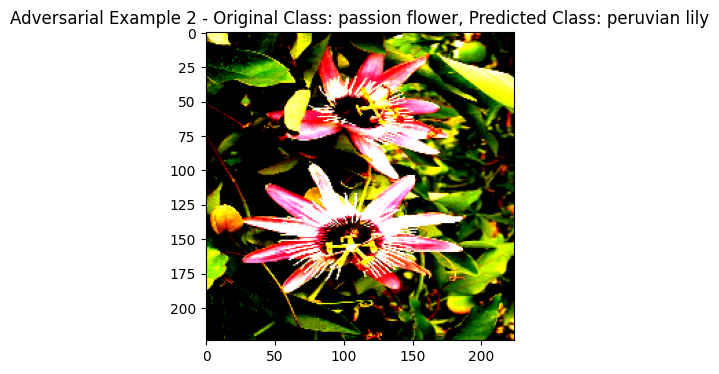

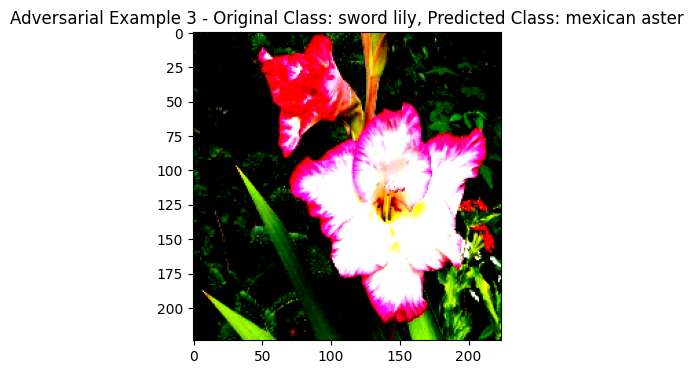

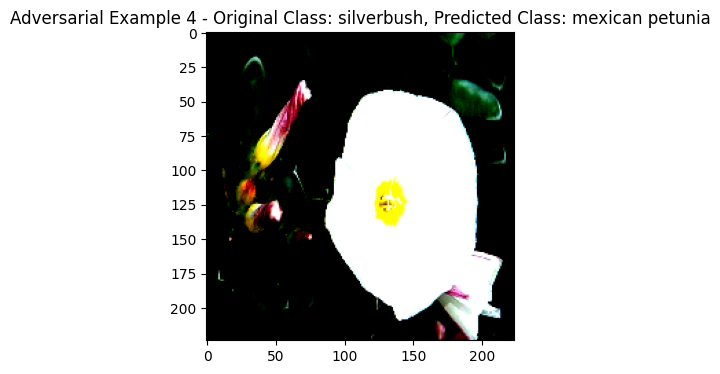

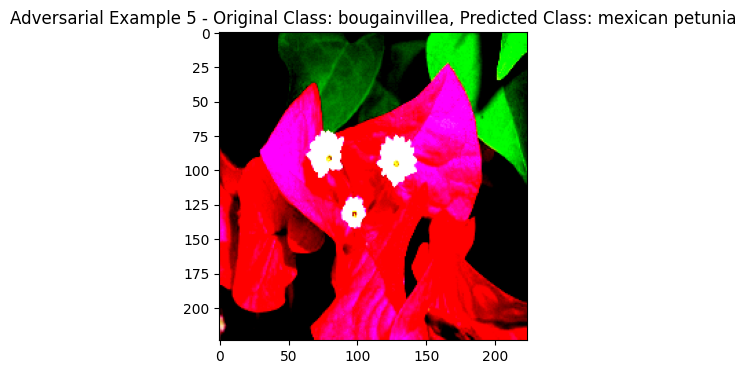

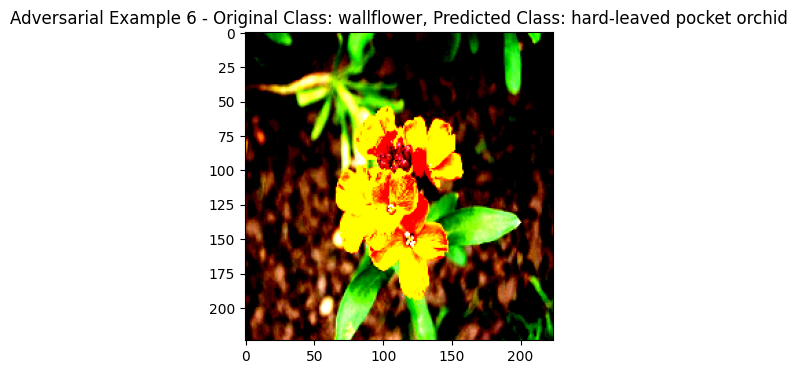

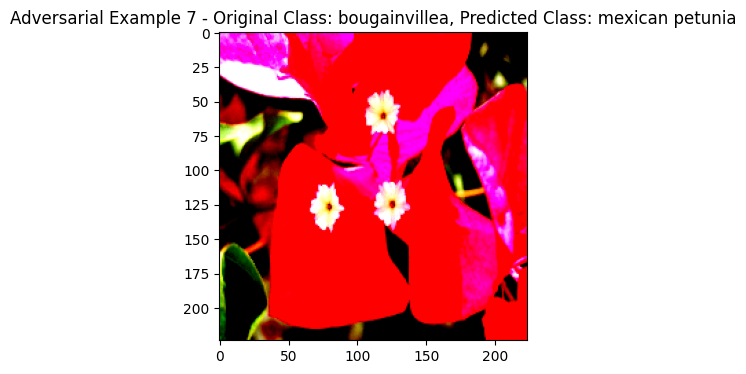

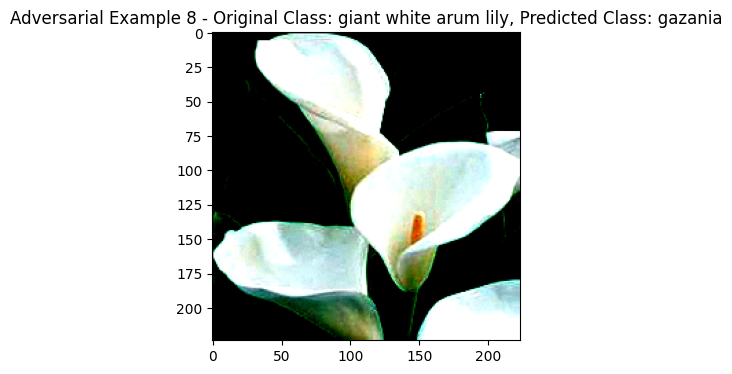

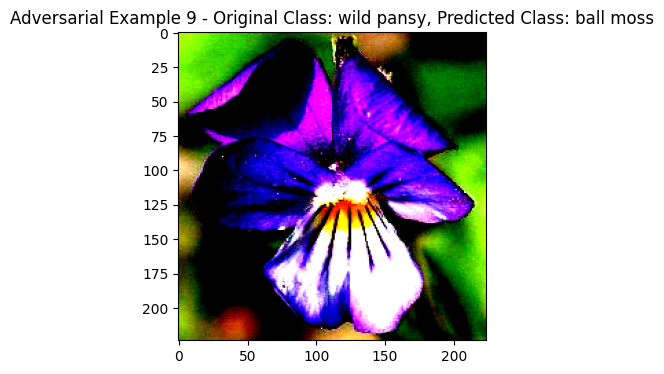

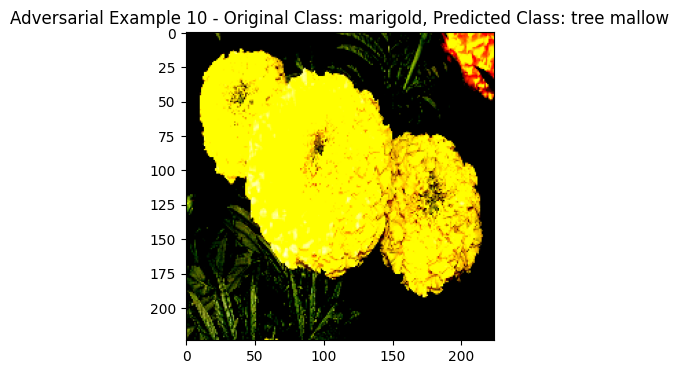

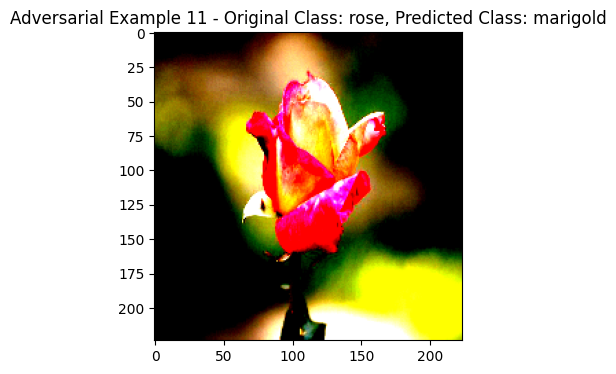

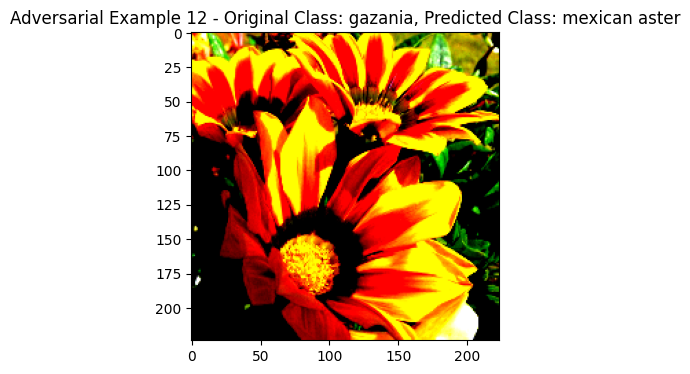

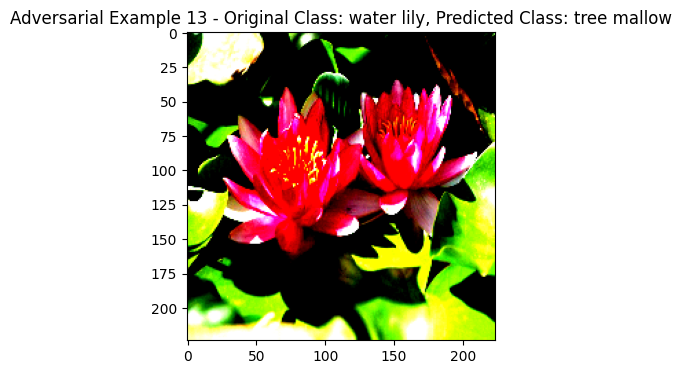

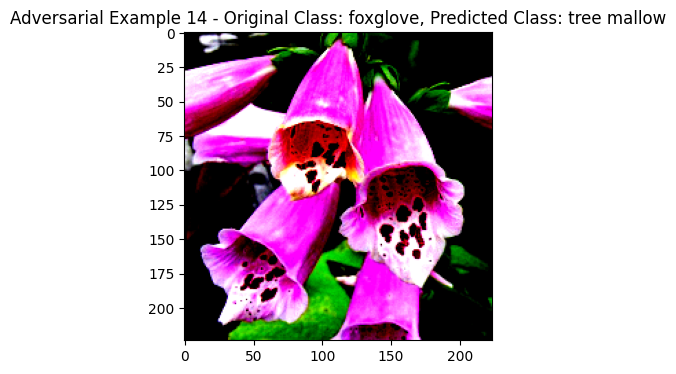

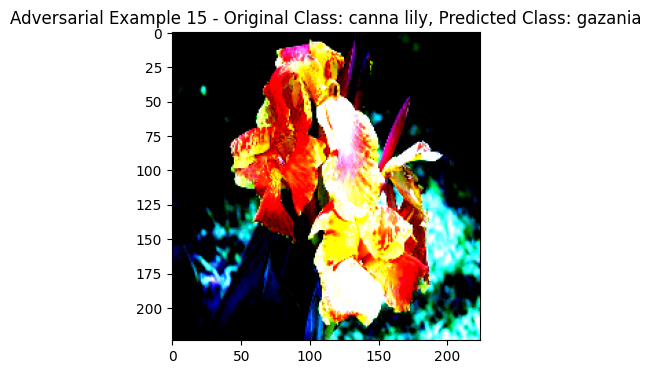

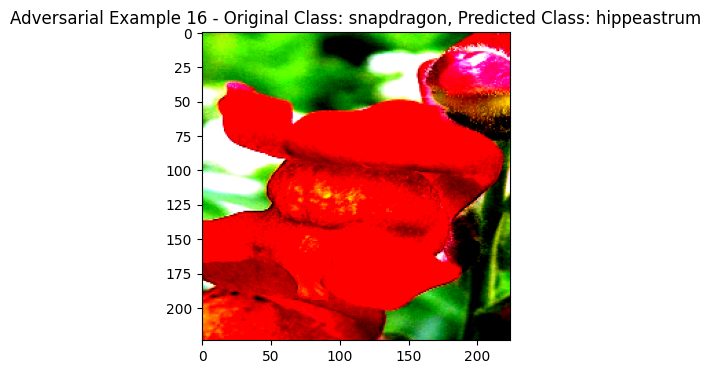

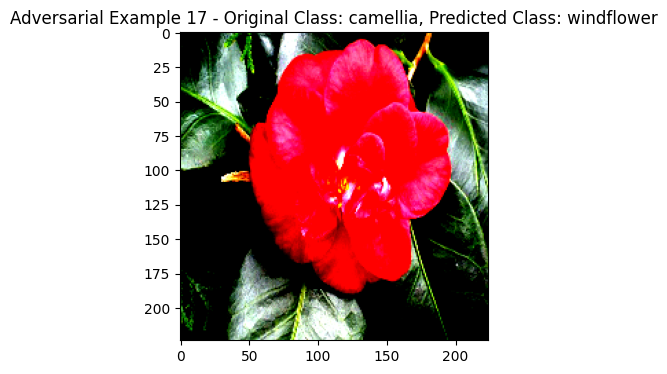

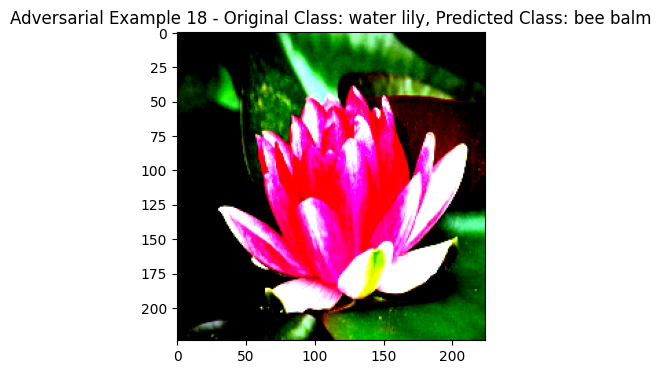

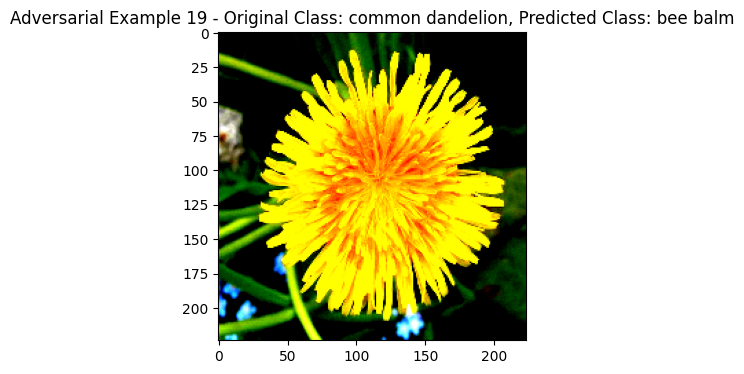

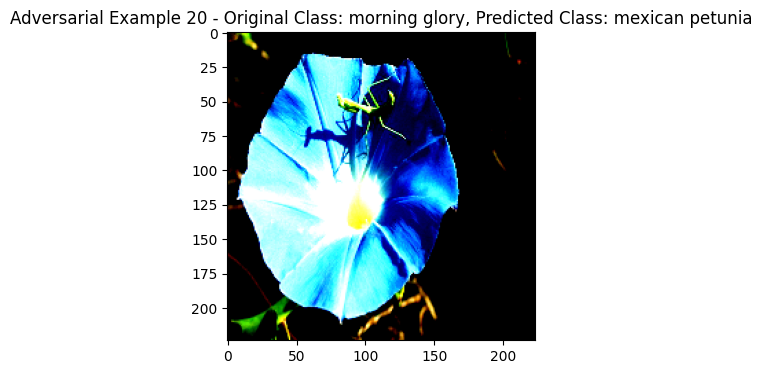

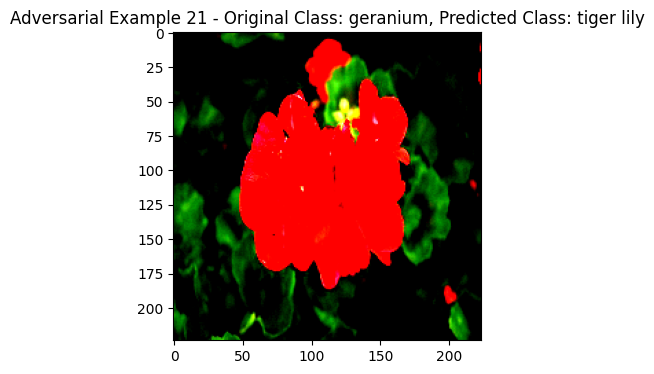

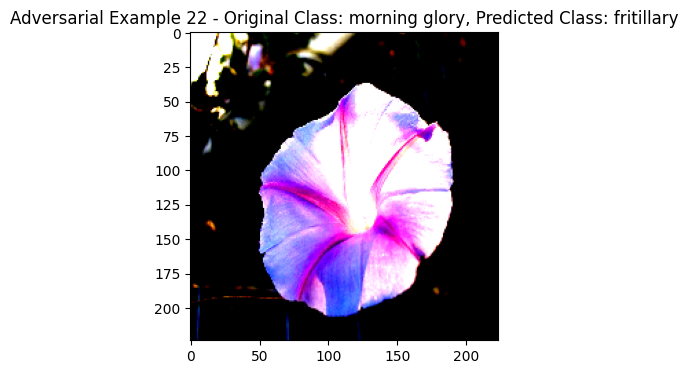

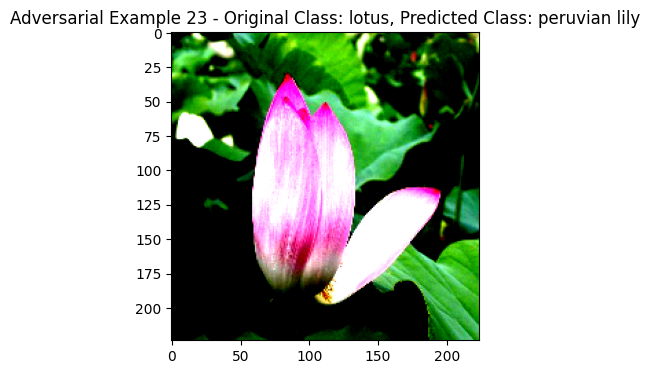

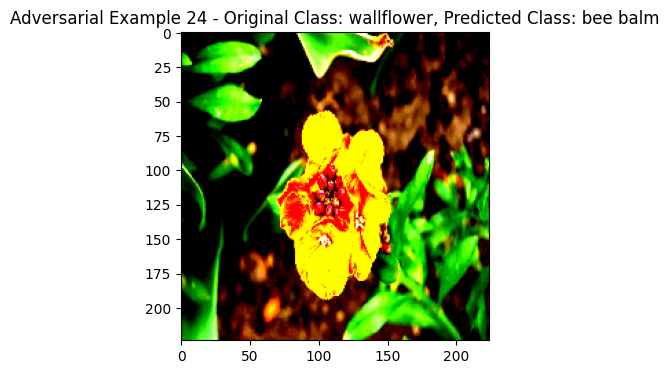

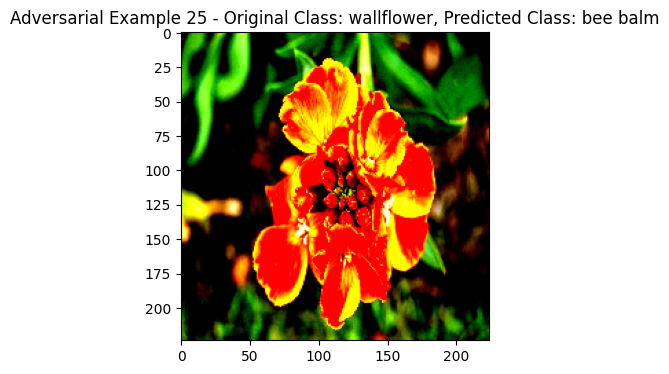

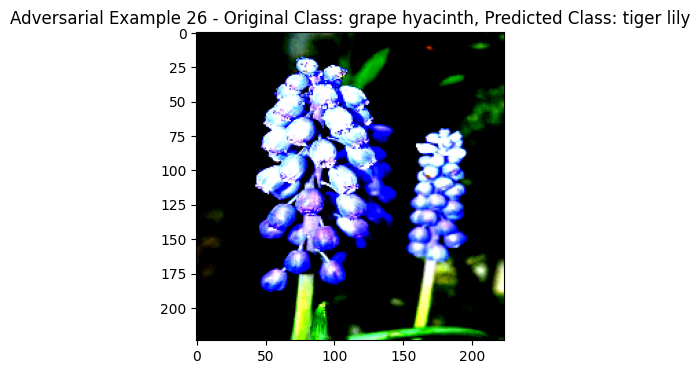

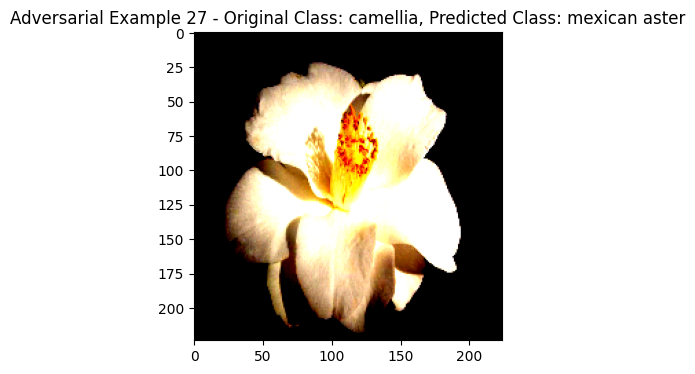

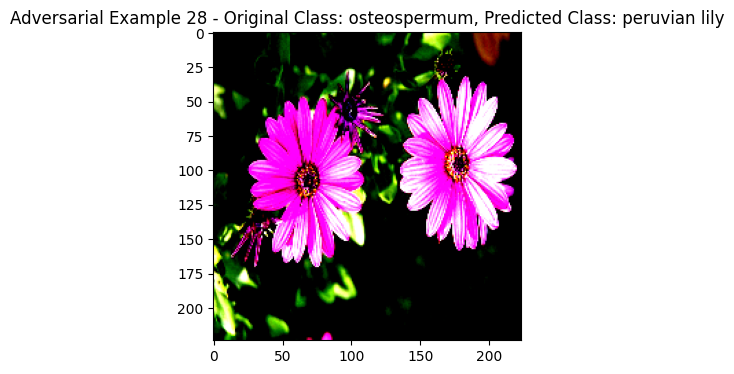

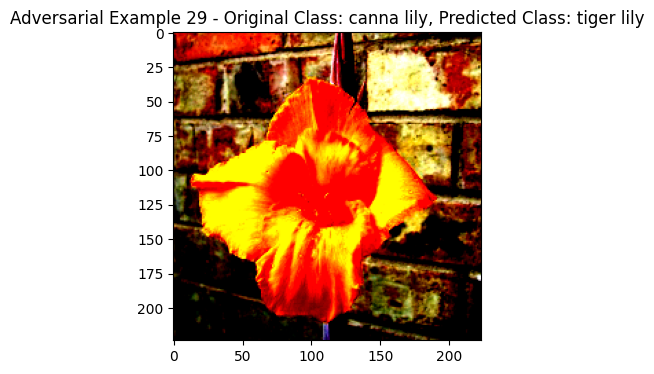

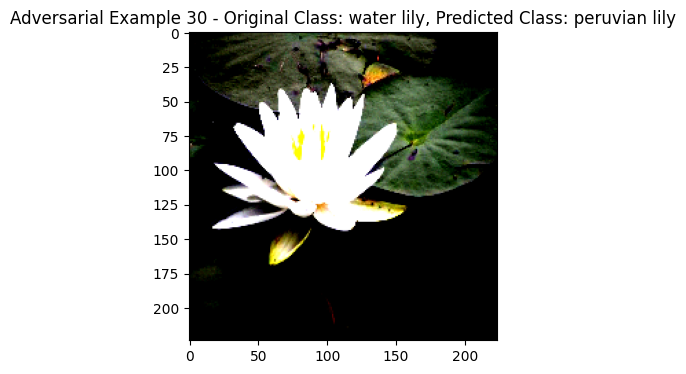

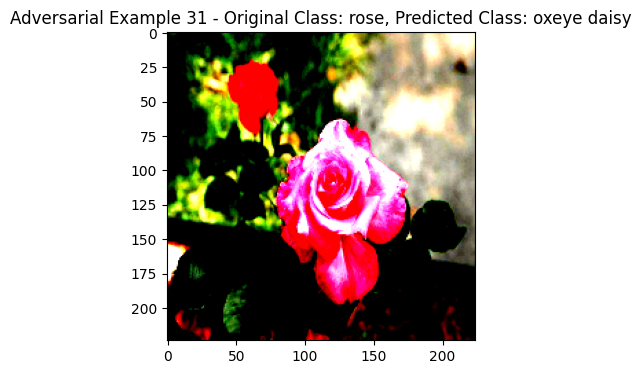

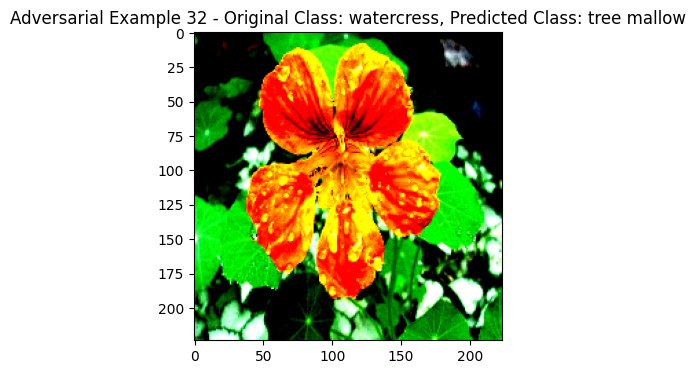

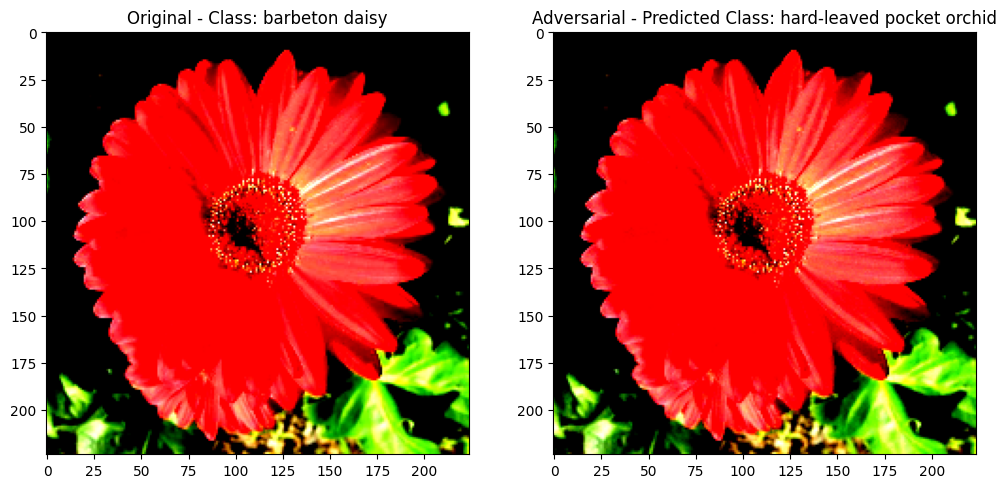

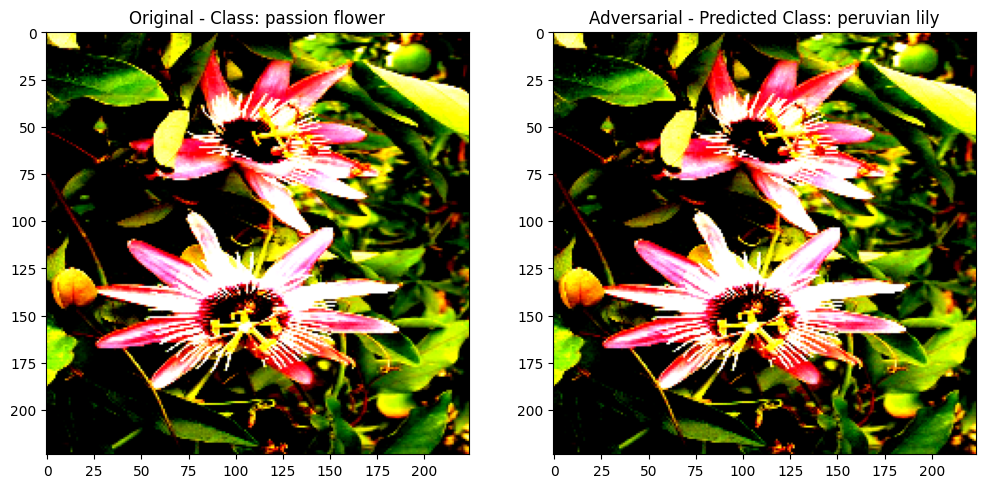

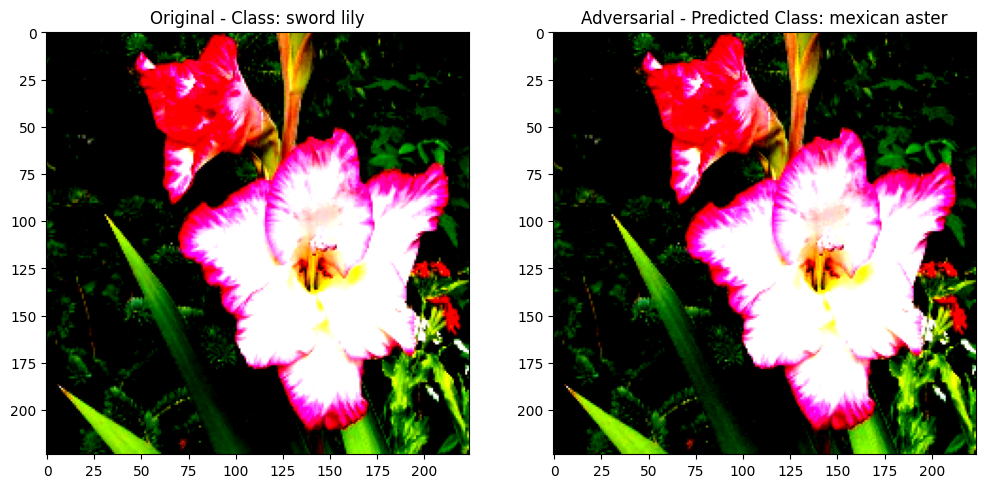

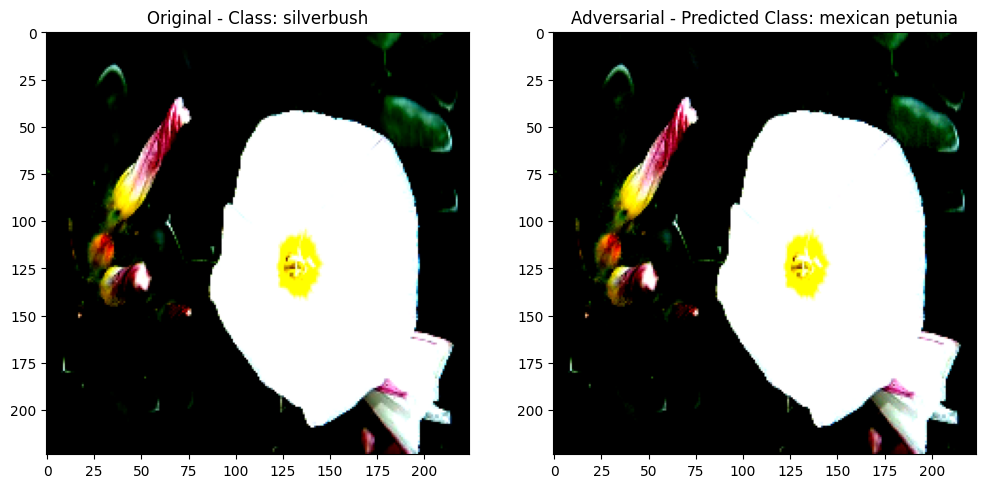

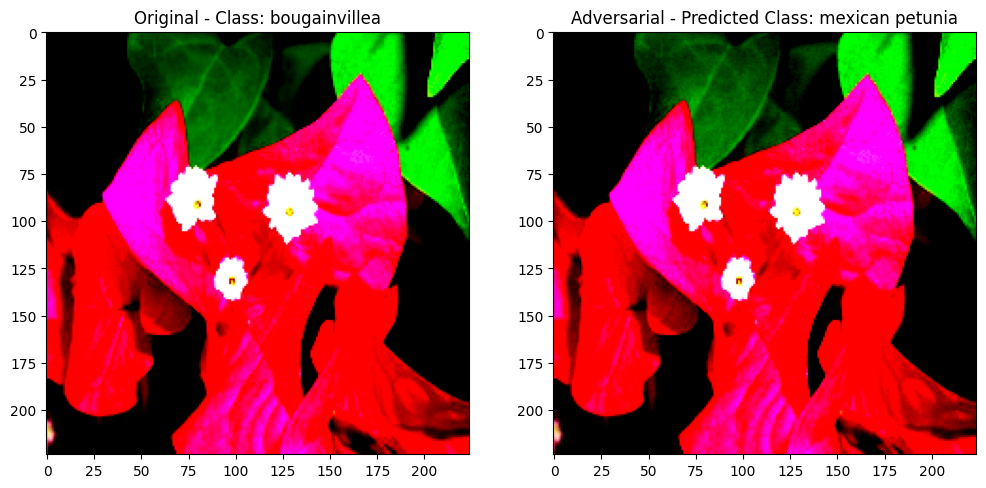

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

dataset, dataset_info = tfds.load('oxford_flowers102', split='test', with_info=True, as_supervised=True)
num_classes = dataset_info.features['label'].num_classes
class_names = dataset_info.features['label'].names
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
test_dataset = dataset.map(preprocess_image).batch(32)
def build_generator(latent_dim):
    model = Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(3, activation='tanh'))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.02)
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
original_class_labels = np.argmax(test_labels, axis=1)
adversarial_test_probs = art_classifier.predict(adversarial_test_images)
adversarial_test_labels = np.argmax(adversarial_test_probs, axis=1)
num_adversarial_images = adversarial_test_images.shape[0]
print(f"Adversarial Test Accuracy: {adversarial_test_acc * 100:.2f}%")
num_display = min(num_adversarial_images, 35)
for i in range(num_display):
    plt.figure(figsize=(8, 4))
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial Example {i + 1} - Original Class: {class_names[original_class_labels[i]]}, Predicted Class: {class_names[adversarial_test_labels[i]]}')
    plt.show()
num_display = min(num_adversarial_images, 5)
for i in range(num_display):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    original_class_index = np.argmax(test_labels[i].numpy())
    plt.title(f'Original - Class: {class_names[original_class_index]}')
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial - Predicted Class: {class_names[np.argmax(art_classifier.predict(adversarial_test_images[i][tf.newaxis, ...]))]}')
    plt.show()

#As I mentioned before, I wanted to attempt to Combine both GAN and the Library which really helped my project, here you can see that I have been able to successfully confuse the model, and able to generate the images with different classes.
#You are able to see that we are able to confuse the AI model when you increase the Epsilons.

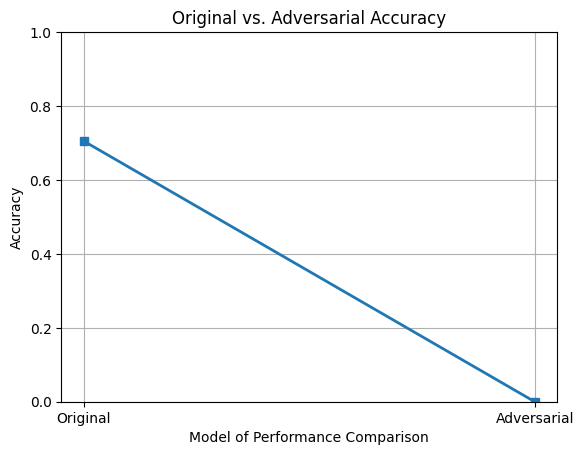

In [ ]:
epochs = np.arange(2)
accuracies = np.array([original_accuracy, adversarial_accuracy])
plt.plot(epochs, accuracies, marker='s', linewidth=2)
plt.xticks(epochs, ['Original', 'Adversarial'])
plt.xlabel('Model of Performance Comparison')
plt.ylabel('Accuracy')
plt.title('Original vs. Adversarial Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.show()
